In [1]:
import gzip
import io
import sys
import time
import unittest
from typing import List
from Point import Point
from TimeSeriesReader import TimeSeriesReader
from datetime import datetime, timedelta
from utilFunction import *
import TestPLA 
from SimPiece import SimPiece
from TestPLA import *
sys.path.append('/home/guoyou/ExtractSemantic/Data/')
path = '/home/guoyou/ExtractSemantic/Data/'
sys.path.append('/home/guoyou/Lossless')
import QuanTRC

In [2]:
filenames = ["Cricket.csv.gz", "FaceFour.csv.gz", "Lightning.csv.gz", "MoteStrain.csv.gz", "Wafer.csv.gz", "WindSpeed.csv.gz", "WindDirection.csv.gz", "Pressure.csv.gz", "Ecg.csv.gz"]
filename = "Cricket.csv"
delimiter = ","

print(filename)
ts = TimeSeriesReader.getTimeSeries(path+filename)
ts.size = os.path.getsize(path+filename)
print("Size = ", ts.size/1048576, "MB")


Cricket.csv
Size =  12.784751892089844 MB


### 1、对原始数据进行处理，获取Base

In [3]:
epsilonPct = 0.01
simPiece = SimPiece(points=ts.data, epsilon=0.5)
binary = simPiece.toByteArray(variableByte=False, zstd=False)
baseSize = simPiece.saveByte(binary, filename)
residuals = simPiece.getResiduals()
residualSize = simPiece.residualEncode(residuals, epsilonPct)

In [4]:
tsDecompressed, decompBaseTime  = simPiece.decompress()
residuals =  [Point(p1.timestamp, p1.value - p2.value) for p1, p2 in zip( ts.data, tsDecompressed)]

In [5]:
max  = 0
for i in range(len(ts.data)):
    diff = abs(ts.data[i].value - tsDecompressed[i].value)
    max = max if(max > diff)  else diff
print("The largest error for base is: ", max)

The largest error for base is:  0.92081126


### 2、画图

/tmp/ipykernel_3981361/1283649287.py:59: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, ax=axes[1, 1], color=color_palette[2])


Mean: -0.024188607912700923
Median: -0.031061968000000006
Standard Deviation: 0.44048947595297544
Skewness: 0.07430009760098938
Kurtosis: -0.8687599976381479


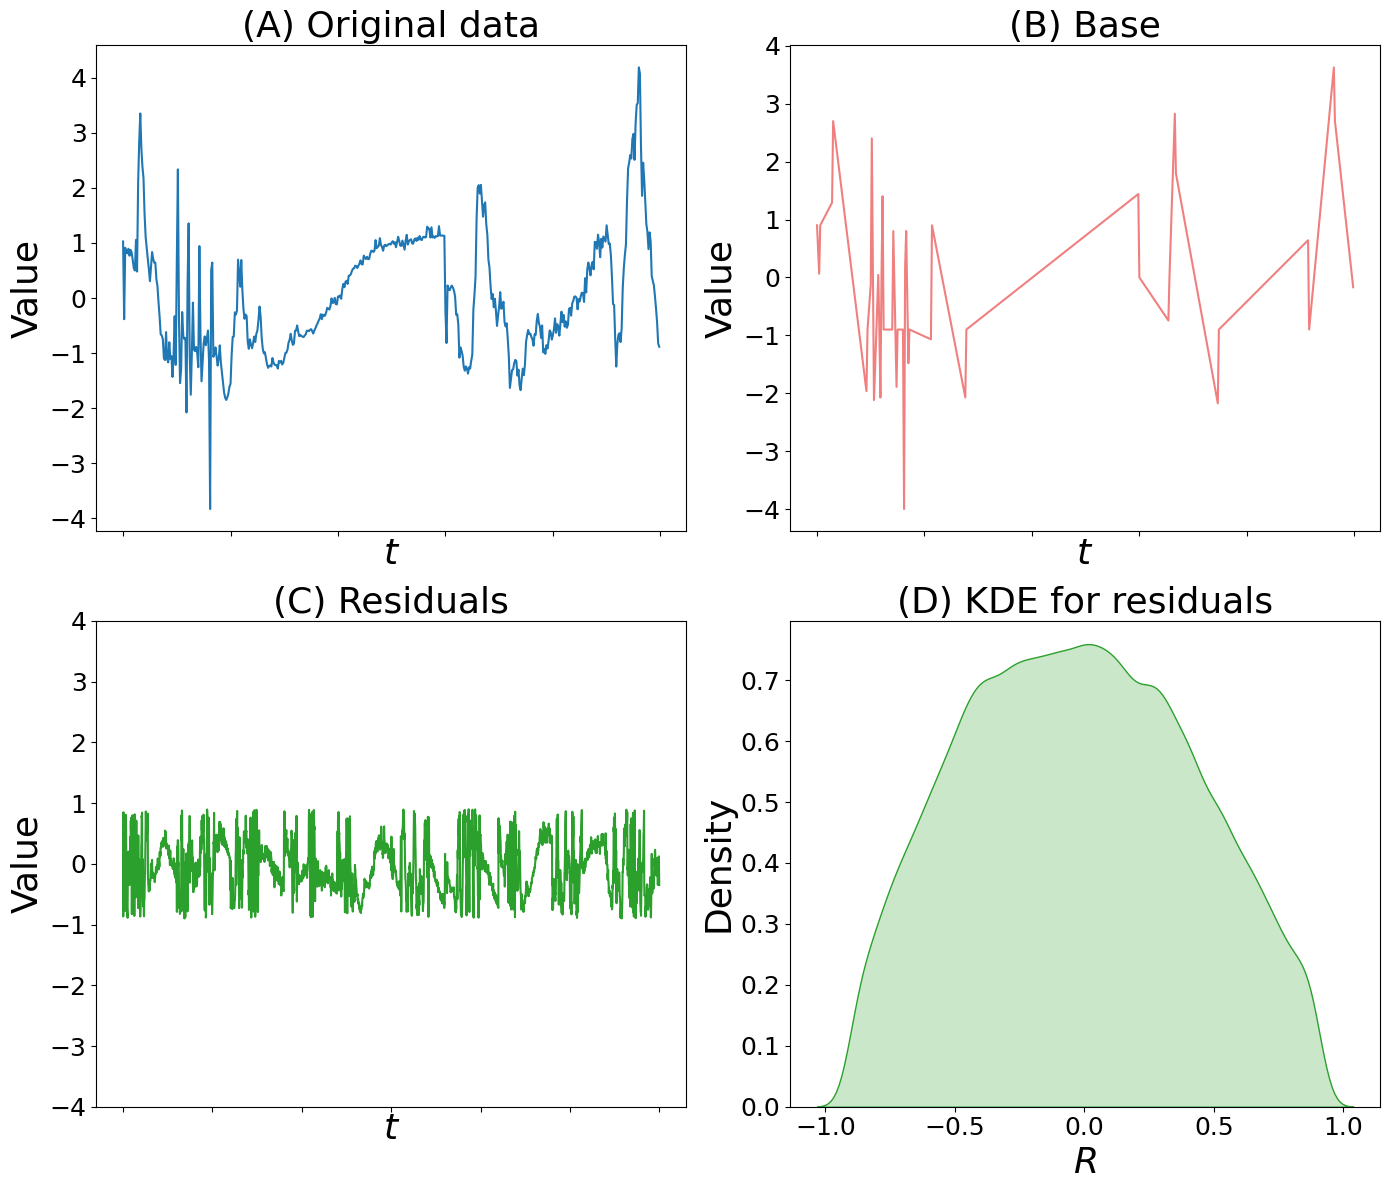

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
# sns.set(style="whitegrid")
#sns.set(font_scale=1.5)

color_palette = sns.color_palette('tab10')
palette = ['lightgreen', 'pink', 'lightblue', color_palette[0]]


# 创建一个Figure对象和Axes对象的数组
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 第一幅图（左上）
timestamps = [point.timestamp for point in ts.data[:500]]
values = [point.value for point in ts.data[:500]]
sns.lineplot(x=timestamps, y=values, color=color_palette[0], ax=axes[0, 0])
axes[0, 0].set_title("(A) Original data", fontsize=26)
axes[0, 0].set_xlabel(r'$t$', fontsize=26)
axes[0, 0].set_ylabel("Value", fontsize=26)
axes[0, 0].grid(False)
axes[0, 0].tick_params(axis='x', which='both', labelbottom=False)
axes[0, 0].tick_params(axis='both', labelsize=18)  # 设置坐标轴刻度字体大小


# 第二幅图（右上）
timestamps = [point.timestamp for point in tsDecompressed[:500]]
values = [point.value for point in tsDecompressed[:500]]
sns.lineplot(x=timestamps, y=values, color='lightcoral', ax=axes[0, 1])
axes[0, 1].set_title("(B) Base", fontsize=26)
axes[0, 1].set_xlabel(r'$t$', fontsize=26)
axes[0, 1].set_ylabel("Value", fontsize=26)
axes[0, 1].grid(False)
axes[0, 1].tick_params(axis='x', which='both', labelbottom=False)
axes[0, 1].tick_params(axis='both', labelsize=18)  # 设置坐标轴刻度字体大小


# 第三幅图（左下）
timestamps = [point.timestamp for point in residuals[:3000]]
values = [point.value for point in residuals[:3000]]
color_palette = sns.color_palette('tab10')
sns.lineplot(x=timestamps, y=values, color=color_palette[2] , ax=axes[1, 0])
axes[1, 0].set_title("(C) Residuals", fontsize=26)
axes[1, 0].set_xlabel(r'$t$', fontsize=26)
axes[1, 0].set_ylim(-4, 4)
axes[1, 0].set_ylabel("Value", fontsize=26)
axes[1, 0].grid(False)
axes[1, 0].tick_params(axis='x', which='both', labelbottom=False)
axes[1, 0].tick_params(axis='both', labelsize=18)  # 设置坐标轴刻度字体大小


# 第四幅图（右下）
data = [p.value for p in residuals[:100000]]
from scipy.stats import gaussian_kde
# from scipy.stats import *
# sns.distplot(data,hist=False,fit=norm)
kde = gaussian_kde(data)
sns.kdeplot(data, shade=True, ax=axes[1, 1], color=color_palette[2])
axes[1, 1].set_title("(D) KDE for residuals", fontsize=26)
axes[1, 1].set_xlabel(r'$R$', fontsize=26)
axes[1, 1].set_ylabel("Density", fontsize=26)
axes[1, 1].grid(False)
axes[1, 1].tick_params(axis='both', labelsize=18)  # 设置坐标轴刻度字体大小

# Get some statistics about the distribution
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)
skewness = np.mean((data - mean) ** 3) / (std_dev ** 3)
kurtosis = np.mean((data - mean) ** 4) / (std_dev ** 4) - 3

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)


# 调整子图之间的间距
plt.tight_layout()

# 保存图像为PDF文件
pdf_filename = '/home/guoyou/ExtractSemantic/figure/compareForAll.pdf'
plt.savefig(pdf_filename, format='pdf')

plt.show()


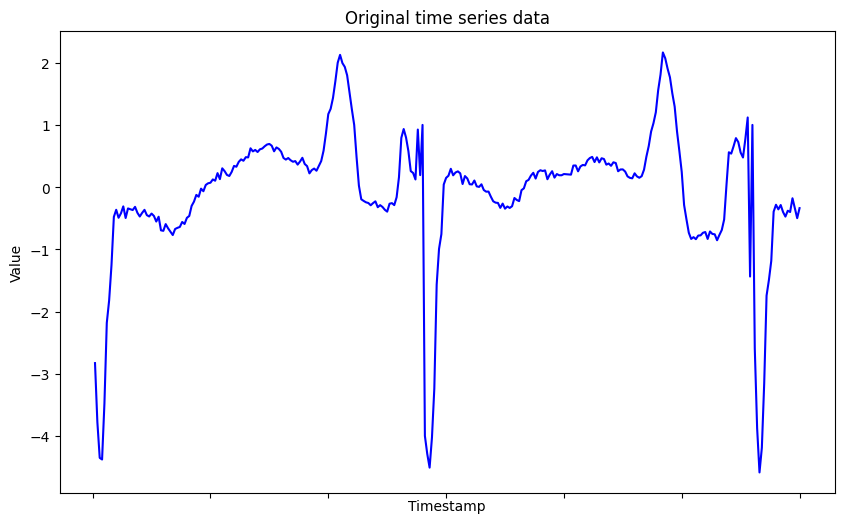

In [7]:
plot_simpleline(ts.data[:300], title="Original time series data")

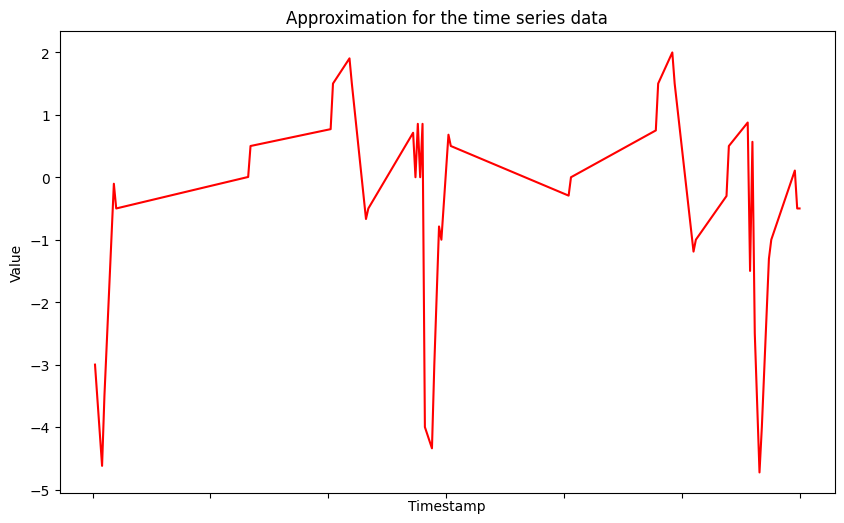

In [9]:
plot_simpleline(tsDecompressed[:300], title="Approximation for the time series data", color="red")

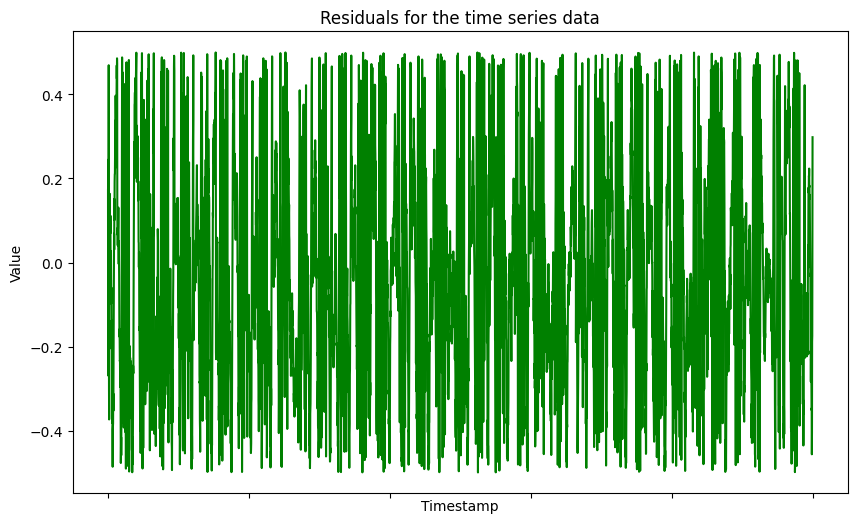

In [8]:
plot_simpleline(residuals[:5000], title="Residuals for the time series data", color="green")

/tmp/ipykernel_1312858/4246163886.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)  # shade参数填充曲线下方区域


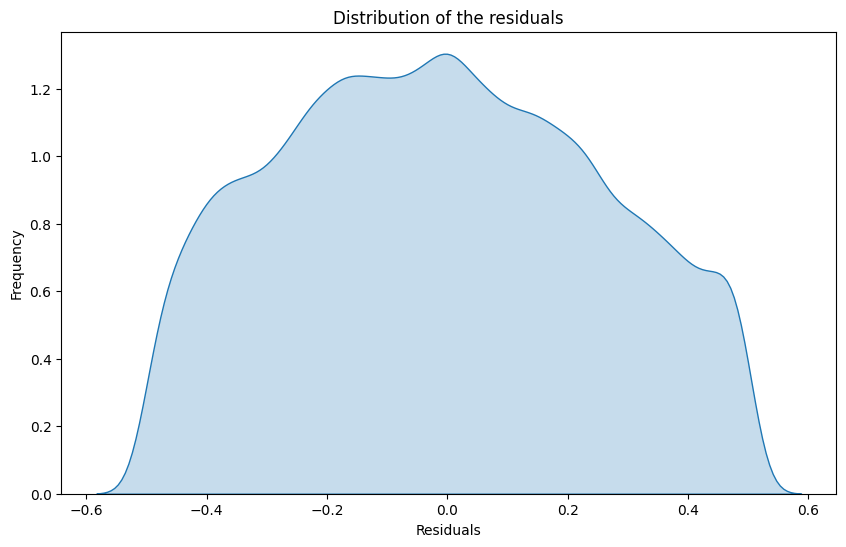

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设data是你的数组
data = [ p.value for p in residuals[:80000]]

plt.figure(figsize=(10, 6))
sns.kdeplot(data, shade=True)  # shade参数填充曲线下方区域
plt.title("Distribution of the residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()


### 3、比较

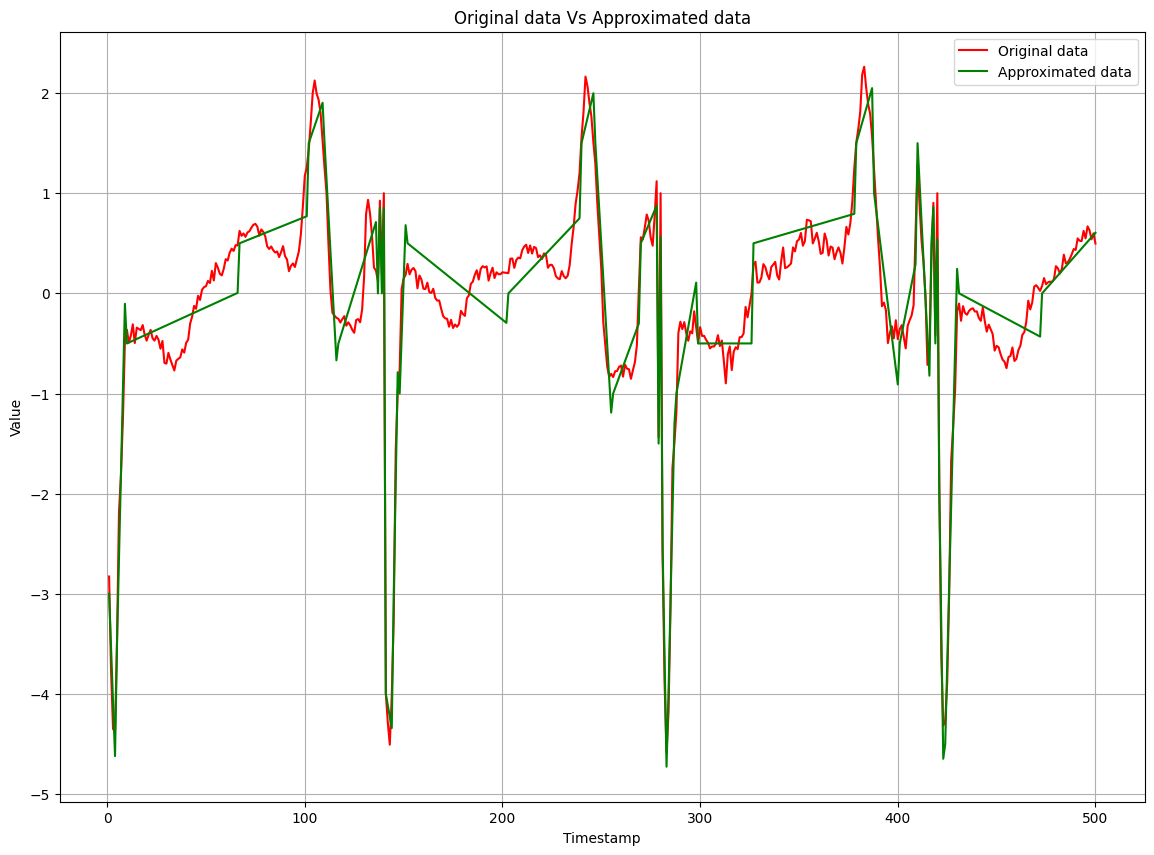

In [11]:
plot_two_line_graphs(ts.data, tsDecompressed, end =500, title="Original data Vs Approximated data")

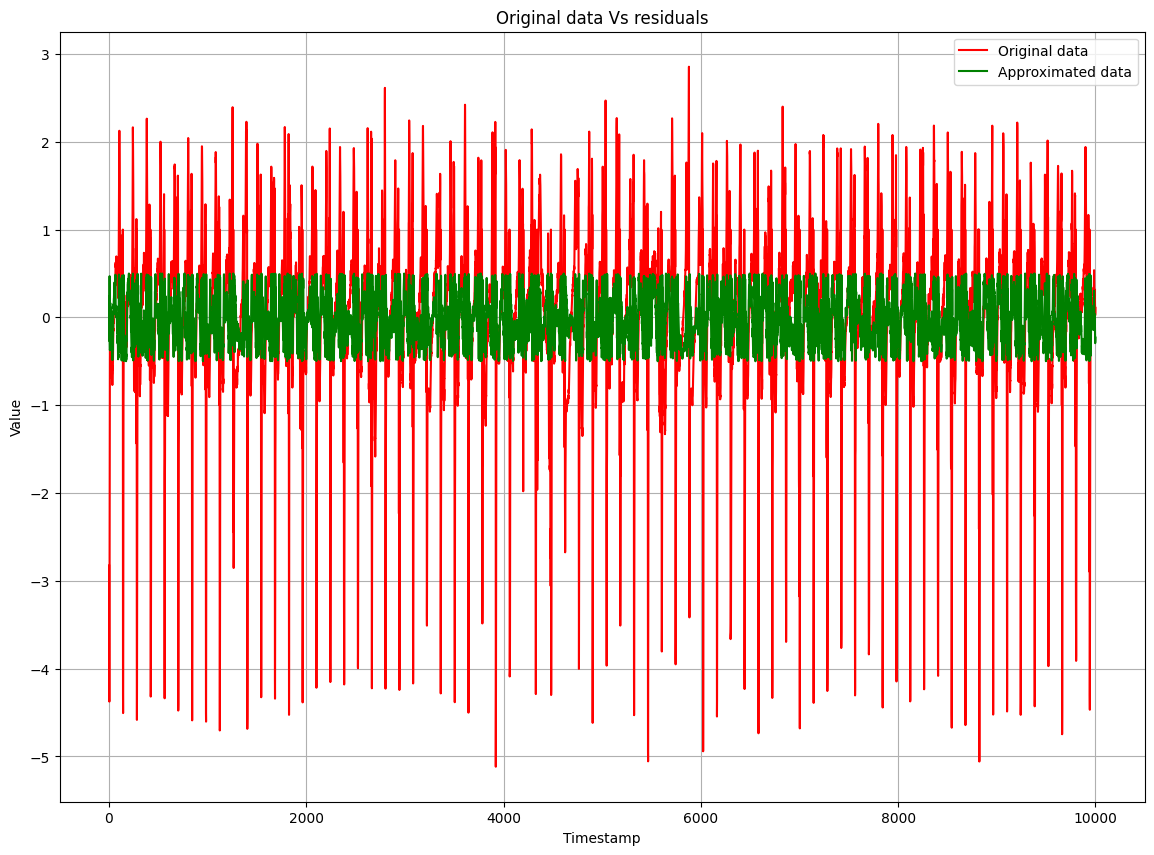

In [12]:
plot_two_line_graphs(ts.data, residuals, end =10000, title="Original data Vs residuals")

### 2、在residual coding加持下的效果

In [15]:
simPiece = SimPiece(points=ts.data, epsilon=0.05 * ts.range)
residuals =simPiece.getResiduals()
resEpsilon = round(ts.range * epsilonPct, 2)
residualSize = simPiece.residualEncode(residuals, resEpsilon)

Dequant_val = simPiece.residualDecode(outputPath='/home/guoyou/ExtractSemantic/residuals', epsilon = resEpsilon)
print (len(Dequant_val))

TypeError: getResiduals() missing 1 required positional argument: 'resEpsilon'

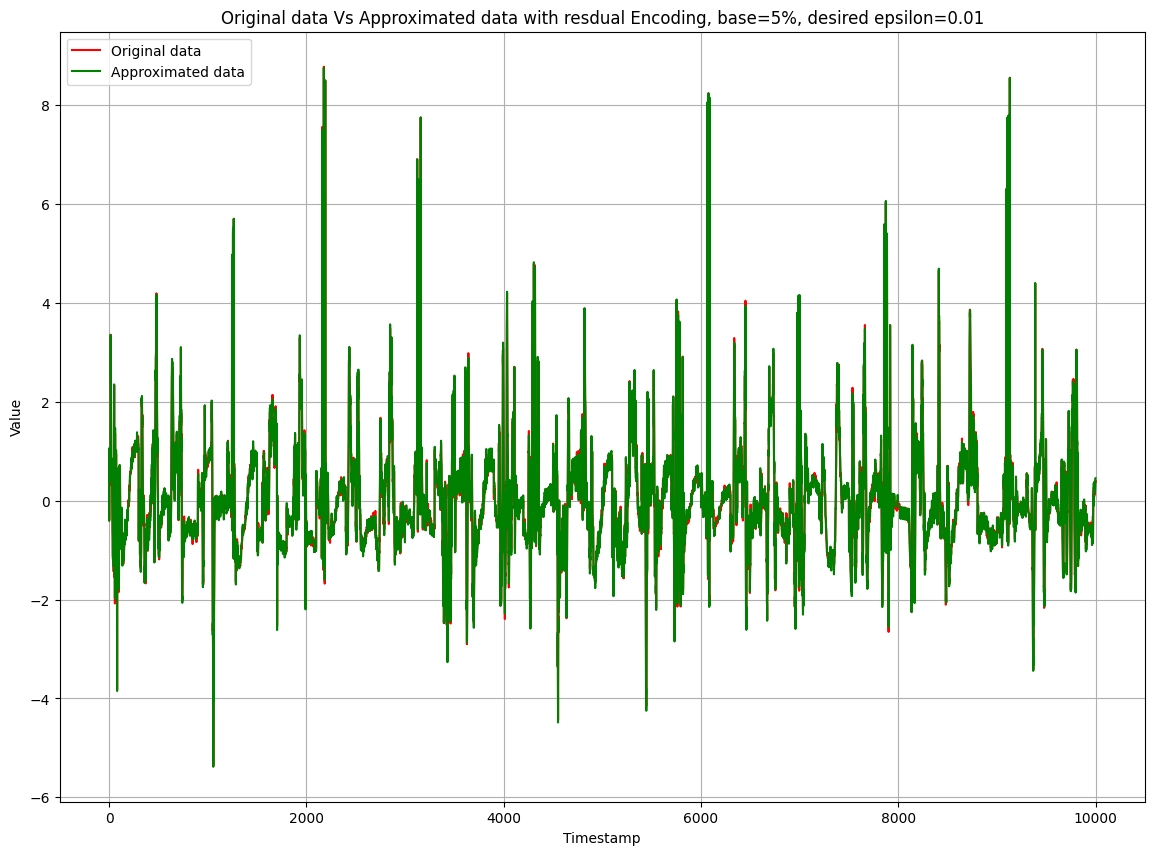

In [8]:
approx = []
for i in range(len(tsDecompressed)):
    approx.append(Point(i,tsDecompressed[i].value+Dequant_val[i]))
plot_two_line_graphs(ts.data, approx, end =10000, title="Original data Vs Approximated data with resdual Encoding, base=5%, desired epsilon="+str(epsilonPct))

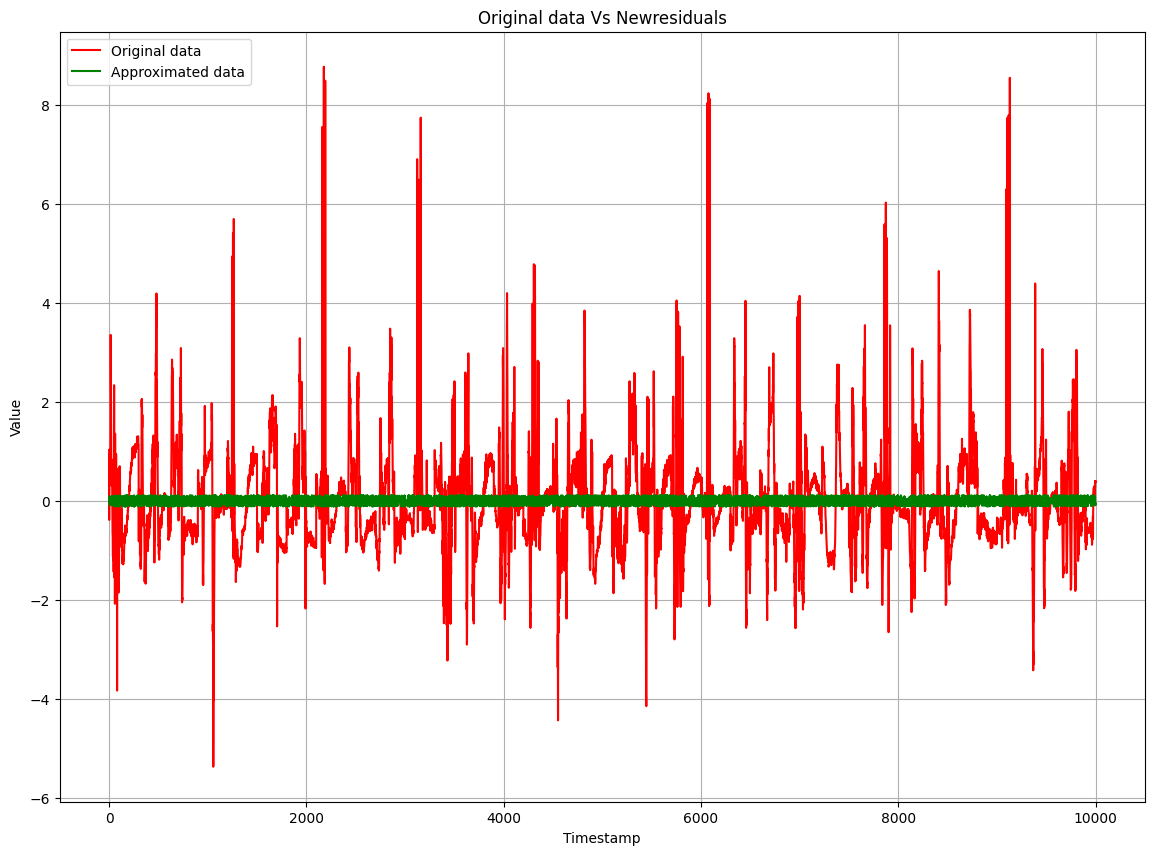

In [9]:
Newresiduals =  [Point(p1.timestamp, p1.value - p2.value) for p1, p2 in zip( ts.data, approx)]
plot_two_line_graphs(ts.data, Newresiduals, end =10000, title="Original data Vs Newresiduals")

### 2、对residual进行处理，获取Deviation

In [11]:
print("ts.size = ",ts.size) 
print("Size of points = ", len(ts.data))
print("compressedSize = ",compressedSize)
residualSize  = PLA.PicewiseSegment( residuals, 3, False, False) # range error threhold
print("residualSize = ",residualSize)



ts.size =  5616000
Size of points =  702000
compressedSize =  73195
residualSize =  21


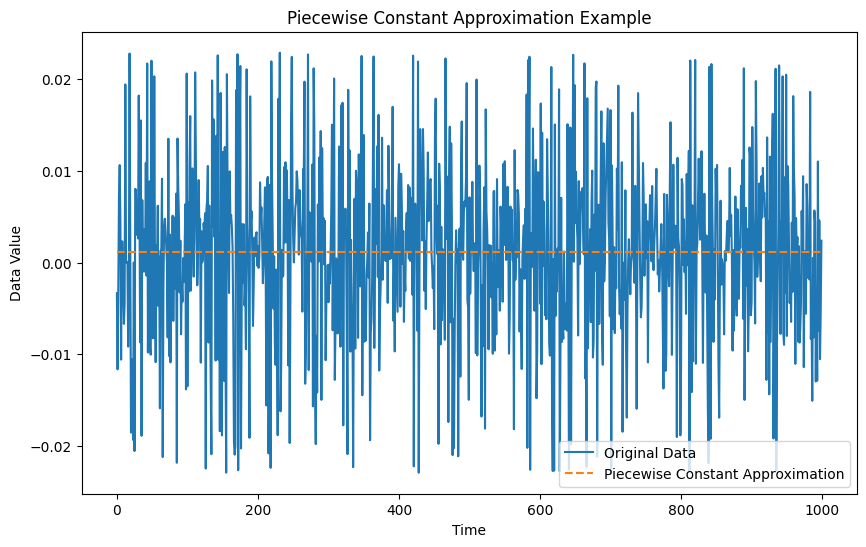

In [12]:
constantPiece = piecewise_constant_approximation([r.value for r in residuals], num_segments=20)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([r.value for r in residuals][:1000], label='Original Data')
plt.plot(constantPiece[:1000], label='Piecewise Constant Approximation', linestyle='--')
plt.legend()
plt.title('Piecewise Constant Approximation Example')
plt.xlabel('Time')
plt.ylabel('Data Value')
plt.show()

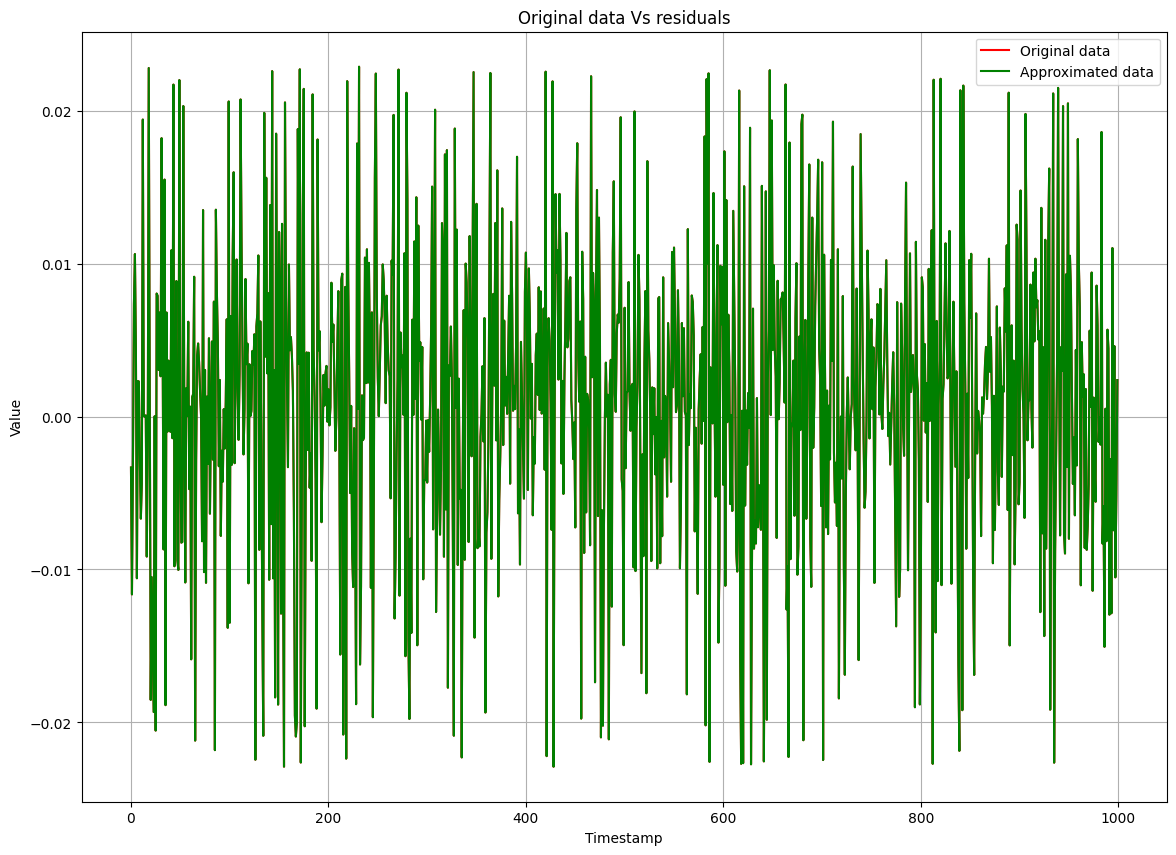

In [13]:
residualDecompressed = PLA.tsDecompressed
Tworesiduals =  [Point(p1.timestamp, p1.value - p2.value) for p1, p2 in zip( residuals, residualDecompressed)]
plot_two_line_graphs(residuals, Tworesiduals, end =1000, title="Original data Vs residuals")

### 3、对residuals进行压缩

In [14]:
print("Length: ", len(residuals))
print(residuals[:3])

Length:  702000
[<Point.Point object at 0x7f27dbddf5e0>, <Point.Point object at 0x7f27dcb47190>, <Point.Point object at 0x7f27dcb47be0>]


In [15]:
resdiaulsVal = [p.value for p in residuals]
print(len(resdiaulsVal))
print(resdiaulsVal[:3])

702000
[-0.003330999499678633, -0.011629176175398825, -0.0028977428886032275]


In [16]:
from utilFunction import *
QuantiresdiaulsVal = float_to_int(resdiaulsVal, errorThre=0.01)
print(len(QuantiresdiaulsVal))
print(QuantiresdiaulsVal[:3])

702000
[ 0 -1  0]


In [22]:
residualSize = 177256 #Bytes
print(f"Epsilon: {epsilonPct * 100:.2f}%\tCompression Ratio: {ts.size / (residualSize+compressedSize):.3f}\tExecution Time: {PLA.duration}ms\tRange Error: {ts.range * epsilonPct:.3f}")

Epsilon: 5.00%	Compression Ratio: 22.424	Execution Time: 602ms	Range Error: 1.145


In [17]:
sys.path.append('/home/guoyou/Lossless')
import QuanTRC
import csv

csv_file_path = "/home/guoyou/ExtractSemantic/residuals/QuantiresdiaulsVal.csv"

with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # 将列表中的每个元素作为一行写入CSV文件
    for item in QuantiresdiaulsVal:
        csv_writer.writerow([item])

print(f"数据已保存到 {csv_file_path}")
    
InFilePath = '/home/guoyou/ExtractSemantic/residuals/QuantiresdiaulsVal.csv'
outputPath = '/home/guoyou/ExtractSemantic/residuals'
QuanTRC.compress(InFilePath,outputPath)
print("Compression Ratio: ", QuanTRC.Calculate_CR('/home/guoyou/ExtractSemantic/residuals/QuantiresdiaulsVal.csv', '/home/guoyou/ExtractSemantic/residuals/codes.rc'))


数据已保存到 /home/guoyou/ExtractSemantic/residuals/QuantiresdiaulsVal.csv
command:  ./Turbo-Range-Coder/turborc -20 /home/guoyou/ExtractSemantic/residuals/QuantiresdiaulsVal.csv /home/guoyou/ExtractSemantic/residuals/codes
Original size:  2280286
CompressedSize 352552
Compression Ratio:  6.467942317729016


sh: 1: ./Turbo-Range-Coder/turborc: not found


### 0、Changes of compression ration

In [ ]:
epsilonPct = 0.05
AdpSimPiece = SimPiece(ts.data, ts.range * epsilonPct, False, False)
CR = AdpSimPiece.AdaptiveMerge(ts.data, ts.range * epsilonPct, False, False)
plot_line_graph([i for i in range(1, len(CR)+1)],CR, title="Compression ratio over time")
#plot_line_graph([i for i in range(1, len(CR)+1)],[1/v for v in CR], title="Compression ratio over time")

In [ ]:
print(len(AdpSimPiece.residuals))
print(AdpSimPiece.residuals[:10])